### Домашнє завдання: Пониження розмірностей для Аналізу Портретів Клієнтів

#### Контекст
В цьому ДЗ ми попрацюємо з методами пониження розмірності на наборі даних для задачі аналізу портретів клієнтів (Customer Personality Analysis). **В попередньому ДЗ ми працювали з цими даними використовуючи кластеризацію, зараз використаємо кластеризацію і візуалізауємо результати з різними методами.**

Customer Personality Analysis - це аналіз різних сегментів клієнтів компанії. Цей аналіз дозволяє бізнесу краще розуміти своїх клієнтів і полегшує процес адаптації продуктів під конкретні потреби, поведінку та інтереси різних типів клієнтів.

Аналіз портретів клієнтів допомагає бізнесу змінювати свій продукт на основі цільової аудиторії, розділеної на різні сегменти. Наприклад, замість того, щоб витрачати гроші на маркетинг нового продукту для всіх клієнтів у базі даних компанії, бізнес може проаналізувати, який сегмент клієнтів найімовірніше придбає продукт, і потім зосередити маркетингові зусилля лише на цьому сегменті.

#### Вхідні дані
Вам надано набір даних з такими атрибутами:

**Характеристики користувачів:**
- `ID`: Унікальний ідентифікатор клієнта
- `Year_Birth`: Рік народження клієнта
- `Education`: Рівень освіти клієнта
- `Marital_Status`: Сімейний стан клієнта
- `Income`: Річний дохід домогосподарства клієнта
- `Kidhome`: Кількість дітей у домогосподарстві клієнта
- `Teenhome`: Кількість підлітків у домогосподарстві клієнта
- `Dt_Customer`: Дата реєстрації клієнта у компанії
- `Recency`: Кількість днів з моменту останньої покупки клієнта
- `Complain`: 1, якщо клієнт скаржився за останні 2 роки, 0 - якщо ні

**Продукти:**
- `MntWines`: Сума, витрачена на вино за останні 2 роки
- `MntFruits`: Сума, витрачена на фрукти за останні 2 роки
- `MntMeatProducts`: Сума, витрачена на м'ясні продукти за останні 2 роки
- `MntFishProducts`: Сума, витрачена на рибні продукти за останні 2 роки
- `MntSweetProducts`: Сума, витрачена на солодощі за останні 2 роки
- `MntGoldProds`: Сума, витрачена на золото за останні 2 роки

**Акції:**
- `NumDealsPurchases`: Кількість покупок, зроблених з використанням знижок
- `AcceptedCmp1`: 1, якщо клієнт прийняв пропозицію у першій кампанії, 0 - якщо ні
- `AcceptedCmp2`: 1, якщо клієнт прийняв пропозицію у другій кампанії, 0 - якщо ні
- `AcceptedCmp3`: 1, якщо клієнт прийняв пропозицію у третій кампанії, 0 - якщо ні
- `AcceptedCmp4`: 1, якщо клієнт прийняв пропозицію у четвертій кампанії, 0 - якщо ні
- `AcceptedCmp5`: 1, якщо клієнт прийняв пропозицію у п'ятій кампанії, 0 - якщо ні
- `Response`: 1, якщо клієнт прийняв пропозицію в останній кампанії, 0 - якщо ні

**Взаємодія з компанією:**
- `NumWebPurchases`: Кількість покупок, зроблених через вебсайт компанії
- `NumCatalogPurchases`: Кількість покупок, зроблених за каталогом
- `NumStorePurchases`: Кількість покупок, зроблених безпосередньо у магазинах
- `NumWebVisitsMonth`: Кількість відвідувань вебсайту компанії за останній місяць


Для початку, запустіть код нижче. Всі ці кроки ми робили в попередньому ДЗ і для того, щоб результати кластеризації у нас були схожими, потрібно аби передобробка була однаковою.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [21]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import plotly.express as px
from sklearn.manifold import TSNE



In [2]:
import pandas as pd

# 1. Завантаження даних
df = pd.read_csv('/content/drive/MyDrive/Data Science/kwiga files/marketing_campaign.csv', sep='\t')

# 2. Обробка пропущених значень
df['Income_not_filled'] = df.Income.isna()
df.Income = df.Income.fillna(-1)

# 3. Обробка дати реєстрації
df.Dt_Customer = pd.to_datetime(df.Dt_Customer, format='%d-%m-%Y')
today = df.Dt_Customer.max()
df['days_lifetime'] = (today - df.Dt_Customer).dt.days
df['years_customer'] = df.Year_Birth.apply(lambda x: today.year - x)

# 4. Категоризація рівня освіти
df_education = pd.get_dummies(df.Education, prefix='education').astype(int)
df = pd.concat([df, df_education], axis=1)

# 5. Очищення сімейного стану
marital_status_map = {'Alone': 'Single', 'Absurd': 'Else', 'YOLO': 'Else'}
df['Marital_Status_clean'] = df.Marital_Status.map(marital_status_map)
df_ms = pd.get_dummies(df.Marital_Status_clean, prefix='marital').astype(int)
df = pd.concat([df, df_ms], axis=1)

# 6. Форматування доходу і видалення викиду
df.Income = df.Income.astype(int)
df = df[df.Income != 666666]

# 7. Створення фінального набору даних
X = df.drop(['ID', 'Dt_Customer', 'Education', 'Marital_Status', 'Marital_Status_clean'], axis=1)
X.reset_index(drop=True, inplace=True)

### Завдання 1: Виконання кластеризації та пониження розмірності для візуалізації результатів

Ваше завдання — провести кластеризацію клієнтів та візуалізувати результати кластеризації, використовуючи метод головних компонент (PCA) для пониження розмірності даних.

#### Інструкції:

1. **Вибір ключових характеристик:**
   Давайте обмежимось тільки наступними хараткеристиками для кластеризації цього разу:
   - `Income`: Річний дохід домогосподарства клієнта
   - `Recency`: Кількість днів з моменту останньої покупки клієнта
   - `NumStorePurchases`: Кількість покупок, зроблених безпосередньо у магазинах
   - `NumDealsPurchases`: Кількість покупок, зроблених з використанням знижок
   - `days_lifetime`: Кількість днів з моменту реєстрації клієнта у компанії
   - `years_customer`: Вік клієнта
   - `NumWebVisitsMonth`: Кількість відвідувань вебсайту компанії за останній місяць
   Відберіть в наборі даних `X` лише ці характеристики.

2. **Нормалізація даних:**
   Використайте метод `MinMaxScaler` для нормалізації значень обраних характеристик.

3. **Кластеризація:**
   Проведіть кластеризацію клієнтів, використовуючи метод `KMeans` з трьома кластерами.

4. **Пониження розмірності:**
   Використайте метод головних компонент (PCA) для пониження розмірності даних до трьох компонент.

5. **Візуалізація результатів:**
   Використовуючи plolty express побудуйте 3D-графік розподілу клієнтів у просторі трьох головних компонент, де кольором позначено кластери.

6. **Опишіть, що спостерігаєте:**
   Чи кластеризація чітко розділила дані?

Далі ми детальніше проінтерпретуємо результати візуалізації і пониження розмірностей.

In [4]:
features = ['Income', 'Recency', 'NumStorePurchases',
    'NumDealsPurchases', 'days_lifetime',
    'years_customer', 'NumWebVisitsMonth']
X_selected = X[features]

In [6]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_selected)

In [9]:
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X_scaled)
labels = kmeans.predict(X_scaled)
print(labels)

[2 0 1 ... 1 1 0]


In [11]:
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)

In [13]:
df_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2', 'PC3'])
df_pca['Cluster'] = labels

fig = px.scatter_3d(df_pca, x='PC1', y='PC2', z='PC3', color='Cluster')
fig.show()

**Кластеризація дуже чітко розділила дані на три класи!**

### Завдання 2: Аналіз результатів пониження розмірності

1. **Розрахунок частки поясненої дисперсії:**
   Визначте, яка частка загальної варіації даних пояснюється кожною з трьох головних компонент (PC1, PC2, PC3) за допомогою атрибуту `explained_variance_ratio_` об'єкта PCA. Виведіть результат на екран.

2. **Розрахунок кумулятивної частки поясненої дисперсії:**
   Обчисліть кумулятивну частку поясненої дисперсії для трьох головних компонент, щоб зрозуміти, скільки варіації даних пояснюється першими кількома компонентами.

In [14]:
explained_var_ratio = pca.explained_variance_ratio_
print("Частка поясненої дисперсії для кожної компоненти:")
print("PC1: {:.2%}".format(explained_var_ratio[0]))
print("PC2: {:.2%}".format(explained_var_ratio[1]))
print("PC3: {:.2%}".format(explained_var_ratio[2]))

cumulative_var_ratio = explained_var_ratio.cumsum()
print("Кумулятивна частка поясненої дисперсії для компонент:")
print("PC1 to PC3: {:.2%}".format(cumulative_var_ratio[-1]))

Частка поясненої дисперсії для кожної компоненти:
PC1: 30.20%
PC2: 28.67%
PC3: 25.12%
Кумулятивна частка поясненої дисперсії для компонент:
PC1 to PC3: 83.99%


### Завдання 3: Інтерпретація "Loadings"

Продовжуємо інтерпретацію результатів `PCA`і познайомимось з новим поняттям `loadings`, яке допоможе нам знайти звʼязок між головними компонентами і оригінальними ознаками в наборі даних.

Ми зараз побудували візуалізацію кластерів точок даних в просторі трьох головних компонент. Але хочеться знайти звʼязок між головними компонентами і оригінальними ознаками. Для розуміння, які початкові характеристики даних мають найбільший вплив на ці головні компоненти, ми можемо використати атрибут `components_` методу `PCA`.

#### Що таке `pca.components_`?

`pca.components_` — це масив, який містить коефіцієнти (або "ваги"), що показують внесок кожної вихідної ознаки у кожну з головних компонент. Ці коефіцієнти ще називаються **"loading"** або "навантаженнями" компонент.

- **Loadings** (`навантаження`) відображають важливість кожної змінної (ознаки) для відповідної головної компоненти. Вони показують, яким чином змінні поєднуються, щоб утворити нові, зменшені вимірювання.
- Якщо коефіцієнт має високе абсолютне значення (як позитивне, так і негативне), це вказує на те, що відповідна змінна сильно впливає на головну компоненту.

#### Саме завдання
Ваше завдання — обчислити "навантаження" для кожної з головних компонент і інтерпретувати результати.

1. **Обчислення loadings для компонент:**
   Використайте атрибут `components_` об'єкта PCA для створення DataFrame, який відображатиме внесок кожної вихідної ознаки в кожну головну компоненту.

2. **Інтерпретація результатів:**
   Виведіть значення "навантажень" і проаналізуйте, які ознаки найбільше впливають на кожну головну компоненту.

In [15]:
loadings = pd.DataFrame(pca.components_.T, columns=['PC1', 'PC2', 'PC3'], index=features)
print("Навантаження компонент:")
print(loadings)

Навантаження компонент:
                        PC1       PC2       PC3
Income             0.063557 -0.047082  0.373826
Recency            0.475786  0.878876  0.029910
NumStorePurchases  0.284282 -0.187195  0.816668
NumDealsPurchases  0.103049 -0.059324 -0.050687
days_lifetime      0.821912 -0.431061 -0.305490
years_customer     0.012658  0.001022  0.080411
NumWebVisitsMonth  0.049530 -0.031377 -0.300089


**Висновок: **
**PC1**
Найбільше навантаження в PC1 має ознака days_lifetime (0.821912), що вказує на сильний вплив кількості днів, протягом яких клієнт зареєстрований у компанії, на цю головну компоненту.
Друге за значенням навантаження має Recency (0.475786), що вказує на вплив кількості днів з останньої покупки.
Третє місце за навантаженням займає NumStorePurchases (0.284282), яке показує внесок кількості покупок у магазині.

**PC2**
Найсильнішим впливом на PC2 має ознака Recency (-0.878876), але з протилежним знаком до PC1, що вказує на зворотний вплив цієї характеристики в рамках цієї компоненти.
days_lifetime також має значний вплив на PC2 (-0.431061), але з протилежним знаком до PC1.

**PC3**
Найбільше навантаження в PC3 має NumStorePurchases (0.816668), що свідчить про значний вплив цієї характеристики на третю головну компоненту.
Друге за значенням навантаження має Income (0.373826), яке показує вплив річного доходу клієнта.

###Завдання 4
Давайте проаналізуємо "навантаження" (**loadings**) для трьох головних компонент після вилучення ознаки `Income`. Це допоможе нам зрозуміти, як змінилася важливість інших ознак для кожної головної компоненти, коли одна з ключових характеристик (`Income`) була вилучена.

#### Кроки для проведення аналізу і ваше завдання:

1. Видаліть ознаку `Income` з нашого набору даних `X` і повторно виконайте PCA (метод головних компонент) для отримання нових "навантажень".

2. Обчисліть нові "навантаження" для трьох головних компонент на наборі даних без `Income`

3. Проаналізуйте, які ознаки мають найбільший вплив на кожну головну компоненту після вилучення `Income`.

4. Перегляньте, наскільки кожна з головних компонент пояснює дисперсію в даних без ознаки `Income`.

In [16]:
features_new = [f for f in features if f != 'Income']
X_selected_new = X[features_new]

scaler_new = MinMaxScaler()
X_scaled_new = scaler_new.fit_transform(X_selected_new)

pca_new = PCA(n_components=3)
X_pca_new = pca_new.fit_transform(X_scaled_new)

In [17]:
loadings_new = pd.DataFrame(pca_new.components_.T, columns=['PC1', 'PC2', 'PC3'], index=features_new)
print("Нові навантаження компонент:")
print(loadings_new)

Нові навантаження компонент:
                        PC1       PC2       PC3
Recency            0.500712  0.865392  0.008648
NumStorePurchases  0.226953 -0.145537  0.924549
NumDealsPurchases  0.105012 -0.065833 -0.027582
days_lifetime      0.825793 -0.472036 -0.232275
years_customer     0.007110  0.005913  0.079808
NumWebVisitsMonth  0.069051 -0.052233 -0.289919


**Висновок**:
**PC1**:
days_lifetime з показником 0.825793 має найбільший вплив на PC1, що свідчить про його домінуючу роль у визначенні довготривалої взаємодії з клієнтами.
Recency з показником 0.500712 все ще має значний вплив, показуючи важливість останніх взаємодій клієнтів.
NumStorePurchases з показником 0.226953 демонструє вплив частоти покупок у магазинах.

**PC2**:
Recency з показником -0.865392 має найвище абсолютне значення зі знаком мінус, відображаючи зворотню взаємодію по відношенню до PC1.
days_lifetime з показником -0.472036 також має значний зворотній вплив, що може вказувати на варіабельність поведінки серед довгострокових та нових клієнтів.

**PC3**:
NumStorePurchases з показником 0.924549 дуже сильно впливає на PC3, що робить цю компоненту вирішальною

### Завдання 5: Візуалізація кластеризації за допомогою t-SNE

Ваше завдання — використати метод t-SNE для візуалізації результатів кластеризації клієнтів у двовимірному просторі. Метод t-SNE допомагає знизити розмірність даних та зберегти локальні структури в даних, що робить його ефективним для візуалізації високорозмірних даних. Ми також зможемо порівняти результат цього методу з РСА.

1. Використайте метод t-SNE для зниження розмірності до 2х вимірів даних, які включають ознаки всі, що і в завданні 1, а також були відмасштабовані перед пониженням розмірностей.

2. Створіть новий DataFrame з координатами, отриманими після застосування t-SNE, та додайте до нього мітки кластерів.

3. Побудуйте інтерактивний 2D-графік розподілу клієнтів, де кольором буде позначено різні кластери і проаналізуйте графік з рекомендаціями нижче (можливо треба буде вивести додаткові візуалізації чи таблиці для інтерпретації, але треба прям зрозуміти, які ознаки формують який кластер і чим кластери відрізняються одне від одного).

  **Опишіть отримані кластери з точки зору ознак.**

4. Опишіть відмінність графіка tSNE від PCA.

#### ЯК можна інтерпретувати з t-SNE?

Хоча t-SNE не надає "компонентів" як РСА, він забезпечує низьковимірне представлення даних, яке можна візуально інтерпретувати:

- **Кластери:** t-SNE особливо добре показує кластери подібних точок. Якщо ви бачите чітко визначені кластери на графіку t-SNE, це свідчить про наявність груп схожих спостережень у ваших даних. Проаналізувати їх можемо, якщо додамо дані в `hover_data` або якщо якісь з даних виведемо як розмір чи форма точок на візуалізації. Також корисно може бути вивести середні значення ознак по кластерам.
- **Локальна структура:** Відносне розташування точок одного кластеру на графіку t-SNE може допомогти вам зрозуміти, які дані подібні між собою.
- **Глобальна структура:** Будьте обережні; t-SNE менш надійний для відображення глобальних структур (наприклад, відстаней між кластерами) у порівнянні з PCA, бо t-SNE націлений на збереження саме локальних структур.

<ipython-input-25-cdd8bcdcce04>:10: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



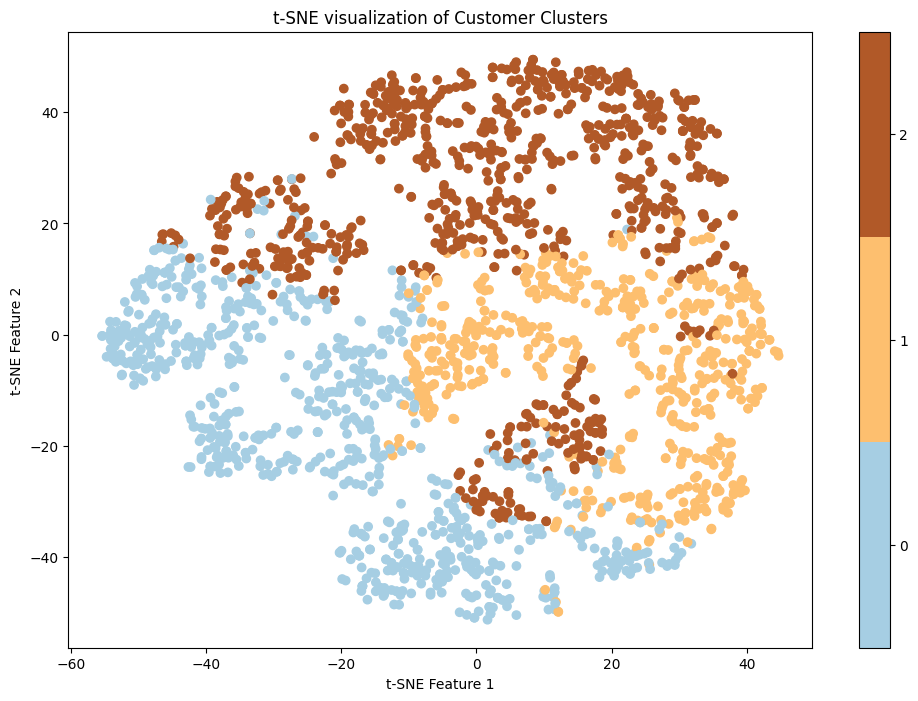

In [25]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=0)
tsne_results = tsne.fit_transform(X_scaled)

# Візуалізація результатів
plt.figure(figsize=(12, 8))
scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=labels, cmap=plt.cm.get_cmap('Paired', len(set(labels))))
plt.colorbar(scatter, ticks=range(len(set(labels))))
plt.clim(-0.5, len(set(labels))-0.5)
plt.title('t-SNE visualization of Customer Clusters')
plt.xlabel('t-SNE Feature 1')
plt.ylabel('t-SNE Feature 2')
plt.show()

Кластери добре розділені, хоча деякі групи точок перетинаються, що може свідчити про подібність між деякими клієнтами з різних кластерів. t-SNE  карще зберігає локальні структури, що робить його більш зручним для візуалізації та інтуїтивного розуміння кластерної структури.